# Spatial Risk of Deforestation and Forest Degradation Assessment
<span style = "font-size: 1.5em;"> ***VT0007 - JNR Risk Mapping Tool*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

JNR risk mapping tool is a standardized methodology in Jurisdictional and nested REDD+ (JNR) requirement for developing deforestation and forest degradation risk maps for users of the JNR Allocation tools. It allows to estimate the spatial distribution of forest under risk of deforestation and forest degradation, built under assumption that forest area near in the deforested region has a higher chance of deforestation.

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile
> - **fcc_directory** : forest cover change

## Data Preparation

### Import modules and Relevant Datasets

In [18]:
%matplotlib inline
# Imports
import os
import multiprocessing as mp
import pkg_resources

import numpy as np
import pandas as pd
from tabulate import tabulate

import riskmapjnr as rmj

from tkinter import Tk, filedialog, simpledialog, messagebox
from tkinter import * 

import time
from IPython.display import Image

In [3]:
# GDAL
os.environ["GDAL_CACHEMAX"] = "1024"

In [4]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.

#shapefile file directory
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
fcc_directory = filedialog.askopenfile(title = "Open Forest Cover Change Raster")

# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

# output directory
out_dir = os.path.expanduser(output_directory+'/JNRMap_RiskAllocation')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Forest Cover Change

Build overview


'C:/Users/FadliUwaisElqorni/OneDrive - SYSTEMIQ Ltd/Documents/Temporary/Revalue/Feasibility Study/Carbon Tanzania/03 JNR Risk Map Test Python package/JNRMap_RiskAllocation\\fcc123.png'

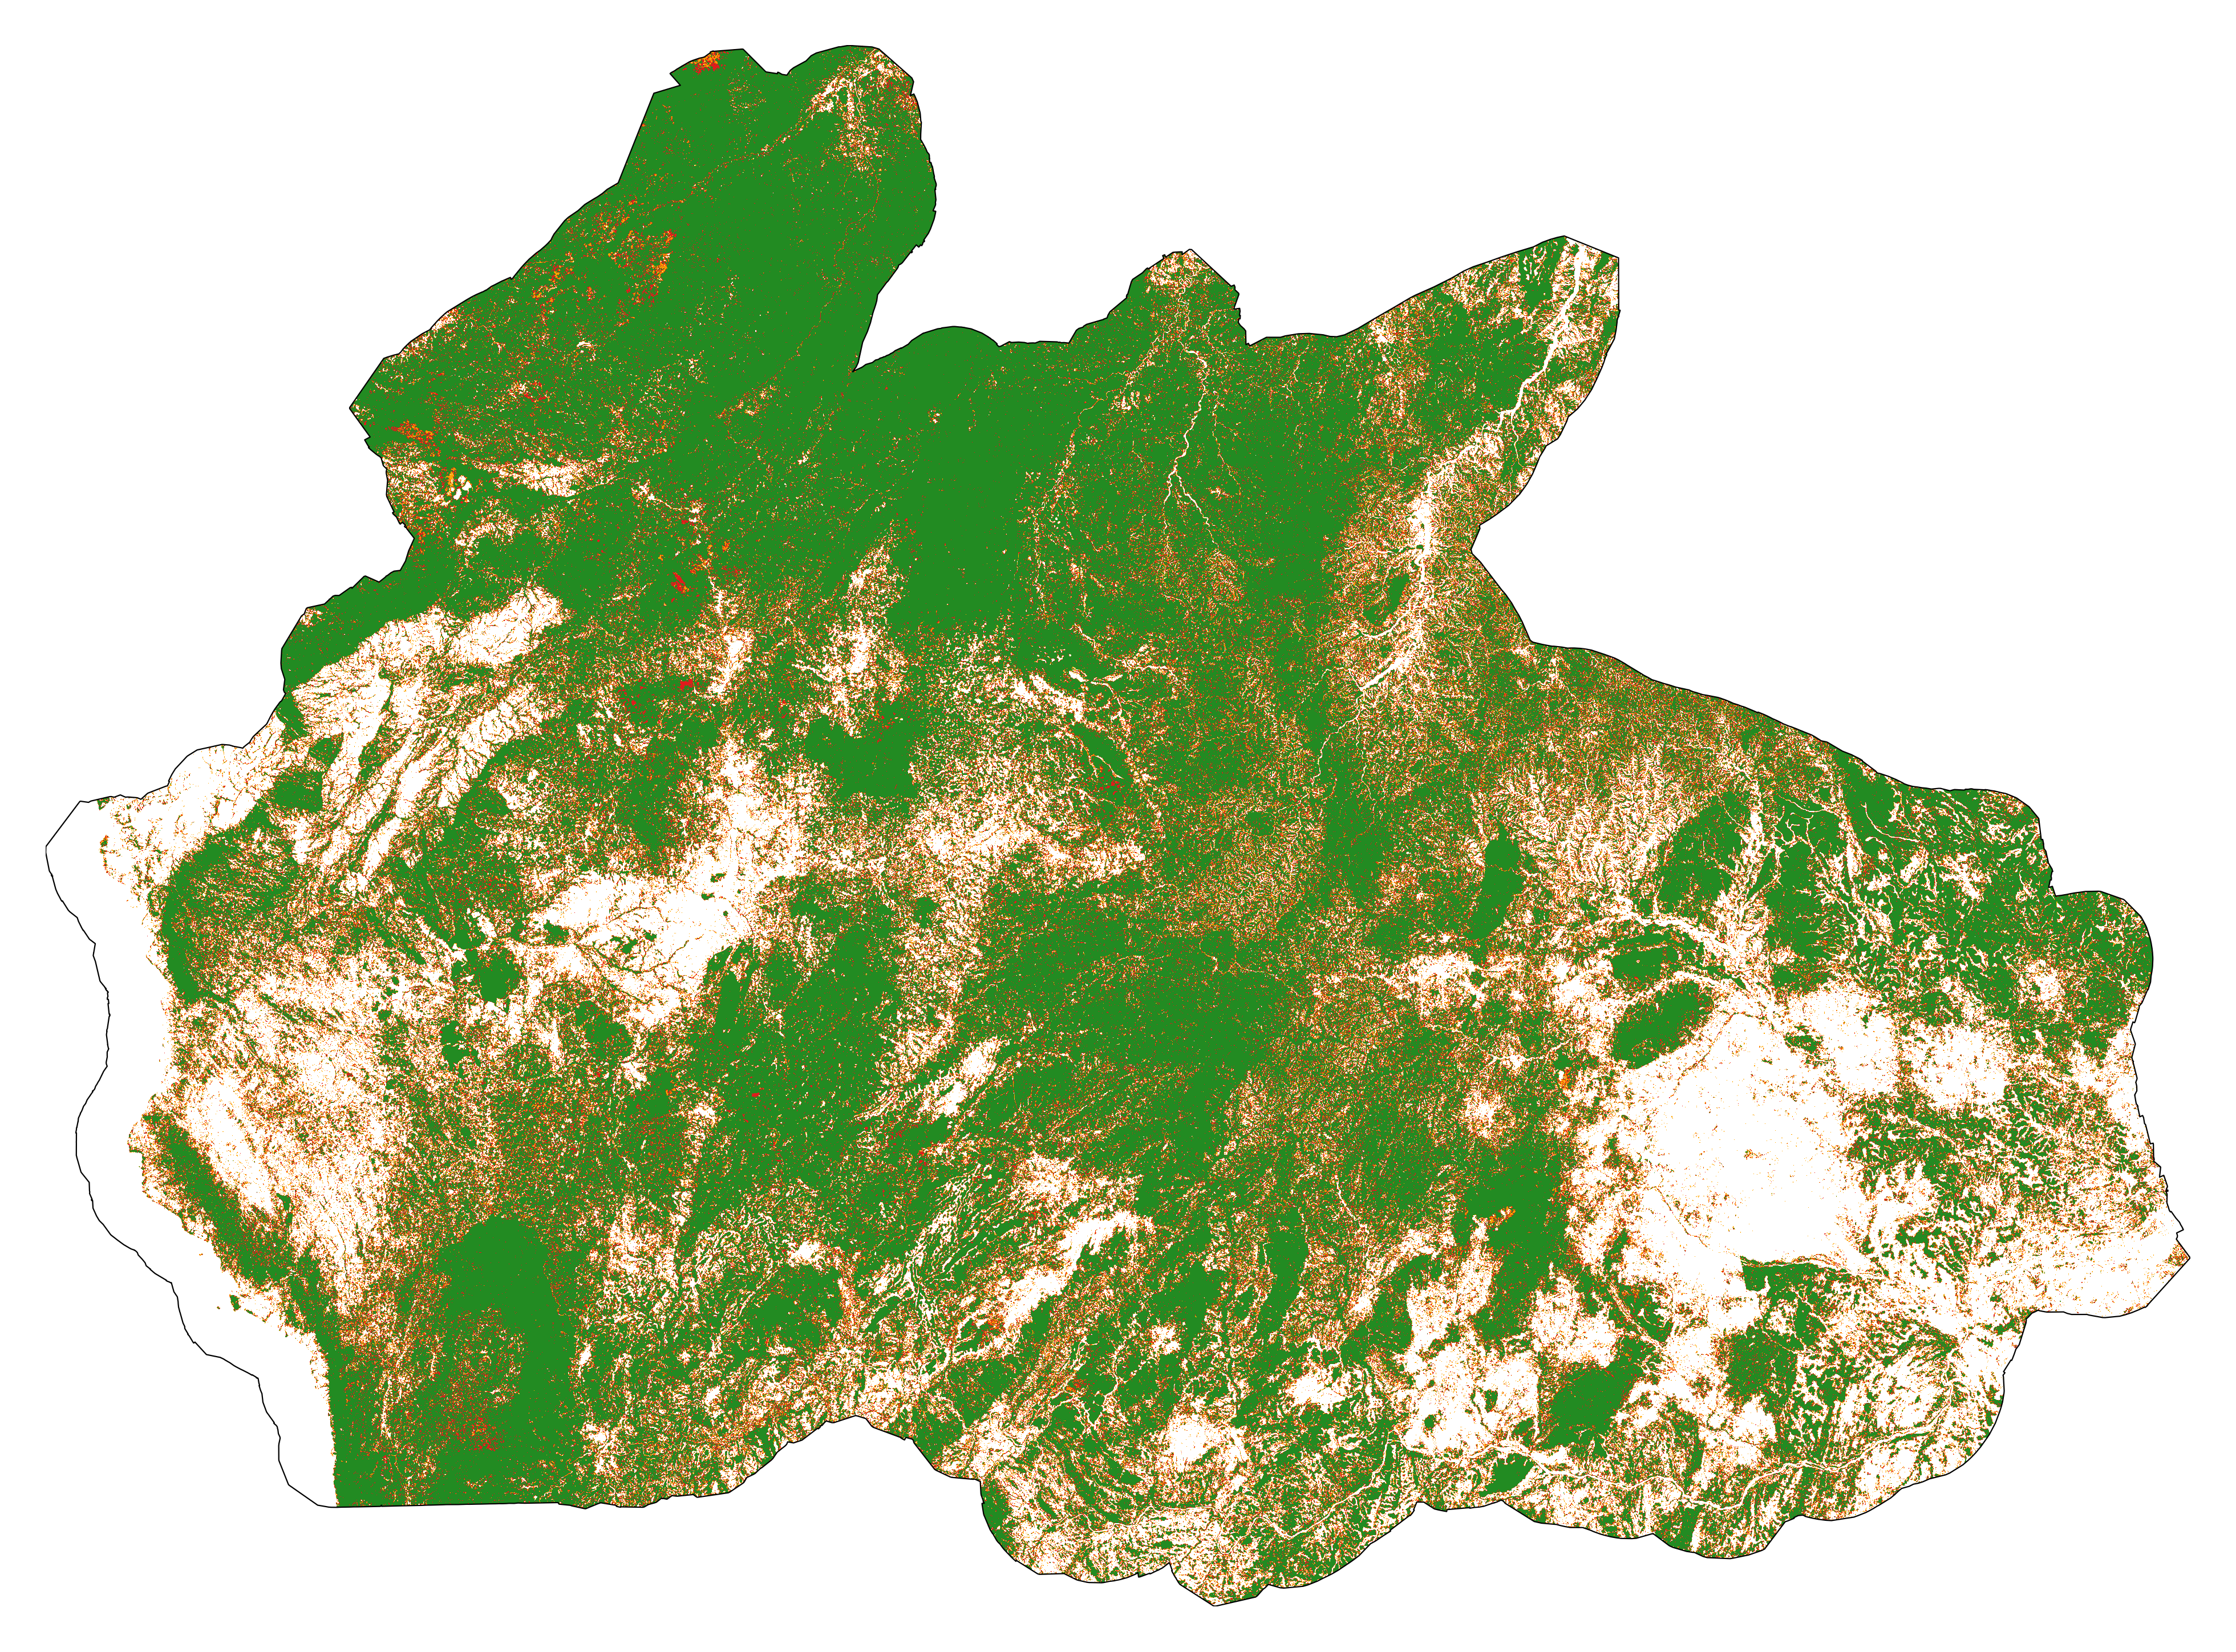

In [5]:
ofile = os.path.join(out_dir, "fcc123.png")
fig_fcc123 = rmj.plot.fcc123(
    input_fcc_raster=fcc_directory.name,
    maxpixels=1e8,
    output_file=ofile,
    borders=roi_directory.name,
    linewidth=0.2,
    figsize=(5, 4), dpi=800)
ofile

## Deforestation Risk Mapping

### Distance to forest edge estimation

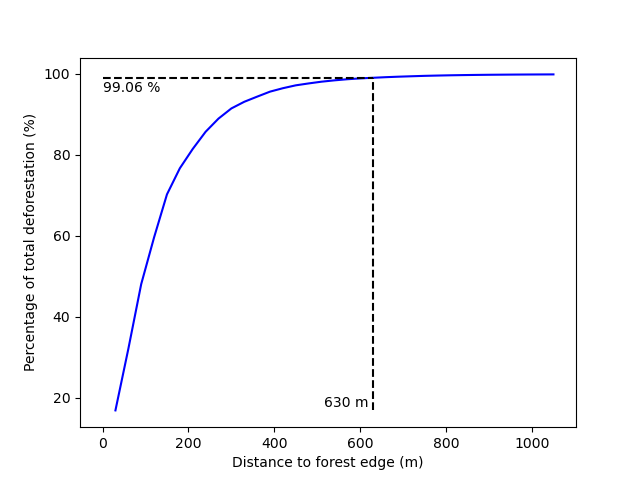

In [20]:
ofile = os.path.join(out_dir, "perc_dist.png")
dist_edge_thres = rmj.dist_edge_threshold(
    fcc_file=fcc_directory.name,
    defor_values=1,
    dist_file=os.path.join(out_dir, "dist_edge.tif"),
    dist_bins=np.arange(0, 1080, step=30),
    tab_file_dist=os.path.join(out_dir, "tab_dist.csv"),
    fig_file_dist=ofile,
    blk_rows=128, verbose=False)
Image(filename = os.path.join(out_dir,'perc_dist.png') )

In [7]:
dist_thresh = dist_edge_thres["dist_thresh"]
print(f"The distance threshold is {dist_thresh} m")

The distance threshold is 630 m


### Local Deforestation Rate

In [8]:
# Set window size
s = 11
# Compute local deforestation rate
rmj.local_defor_rate(
    fcc_file=fcc_directory.name,
    defor_values=1,
    ldefrate_file=os.path.join(out_dir, f"ldefrate.tif"),
    win_size=s,
    time_interval=5,
    blk_rows=100,
    verbose=False)

In [9]:
rmj.set_defor_cat_zero(
    ldefrate_file=os.path.join(out_dir, f"ldefrate.tif"),
    dist_file=os.path.join(out_dir, "dist_edge.tif"),
    dist_thresh=dist_thresh,
    ldefrate_with_zero_file=os.path.join(out_dir, f"ldefrate_with_zero.tif"),
    blk_rows=128,
    verbose=False)

### Categorization of deforestation risk

In [10]:
rmj.defor_cat(
    ldefrate_with_zero_file=os.path.join(out_dir, f"ldefrate_with_zero.tif"),
    riskmap_file=os.path.join(out_dir, "riskmap.tif"),
    ncat=30,
    method="Equal Interval",
    blk_rows=128,
    verbose=False)

'C:/Users/FadliUwaisElqorni/OneDrive - SYSTEMIQ Ltd/Documents/Temporary/Revalue/Feasibility Study/Carbon Tanzania/03 JNR Risk Map Test Python package/JNRMap_RiskAllocation\\riskmap.png'

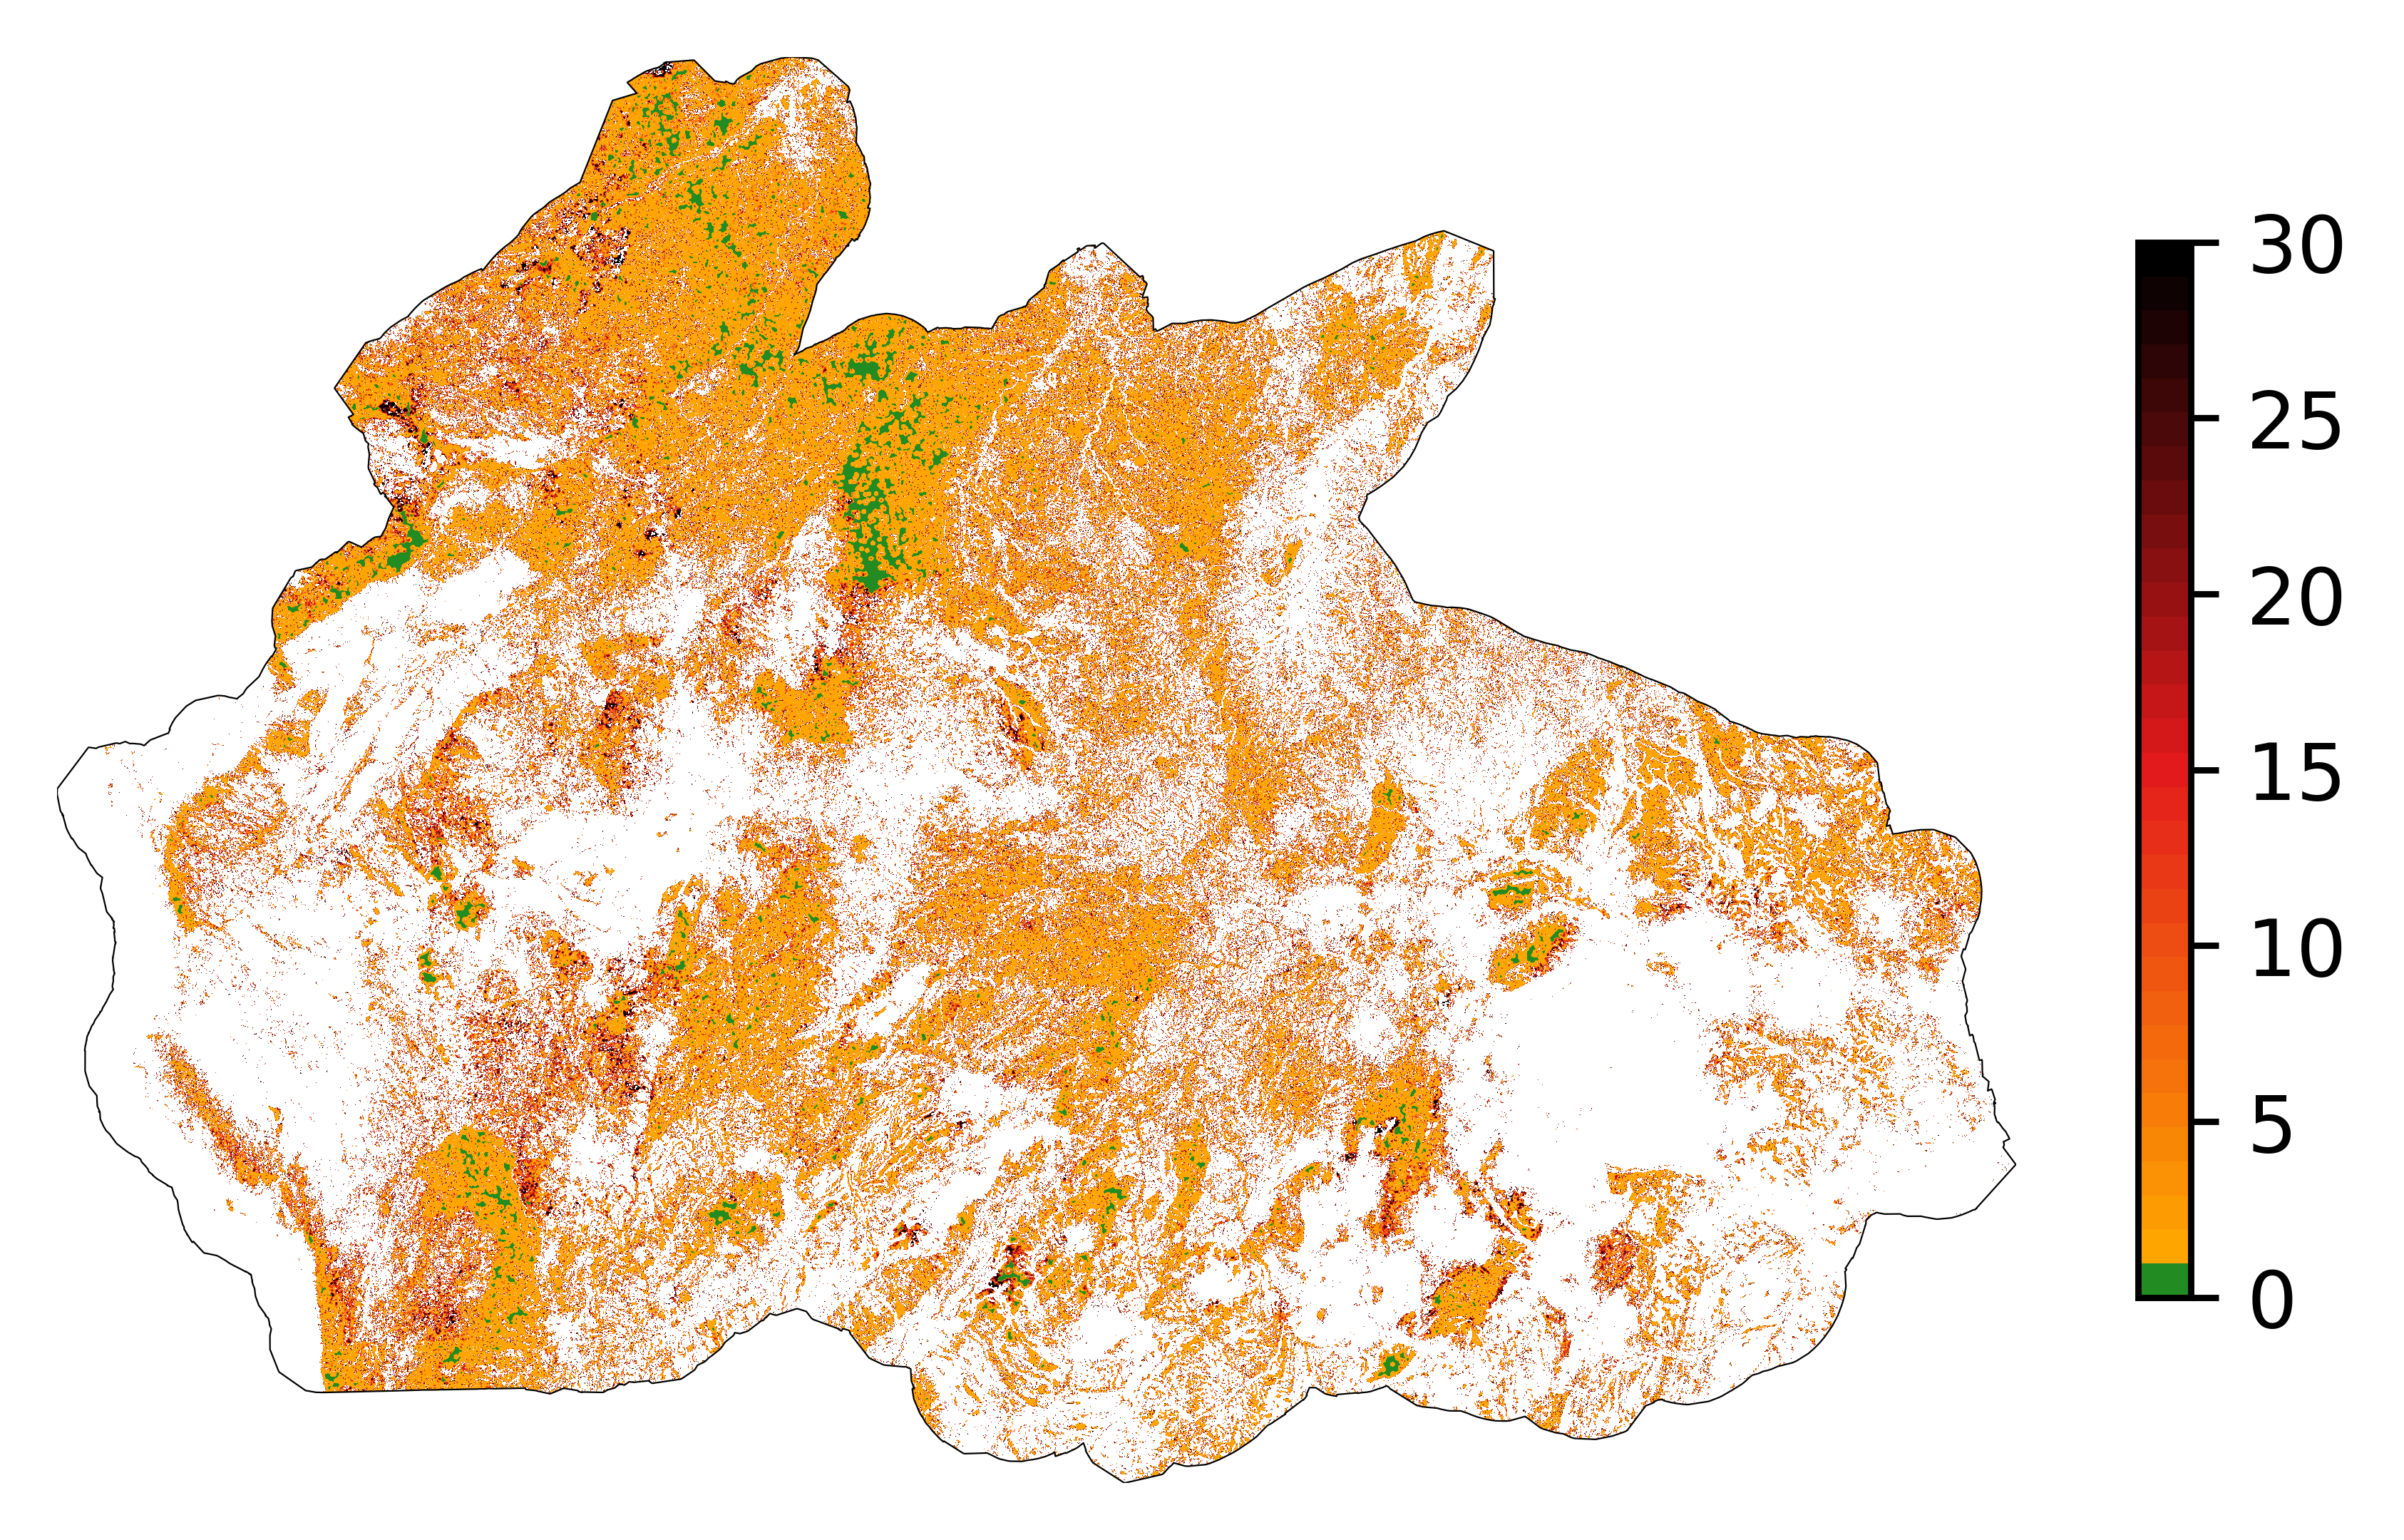

In [12]:
ofile = os.path.join(out_dir, "riskmap.png")
riskmap_fig = rmj.plot.riskmap(
    input_risk_map=os.path.join(out_dir, "riskmap.tif"),
    maxpixels=1e8,
    output_file=ofile,
    borders=roi_directory.name,
    legend=True,
    figsize=(5, 4), dpi=800,
    linewidth=0.2,)
ofile

### Deforestation rates in each risk category

In [14]:
rmj.defrate_per_cat(
    fcc_file=fcc_directory.name,
    defor_values=1,
    riskmap_file=os.path.join(out_dir, "riskmap.tif"),
    time_interval=5,
    tab_file_defrate=os.path.join(out_dir, "defrate_per_cat.csv"),
    blk_rows=128,
    verbose=False)

## Validation

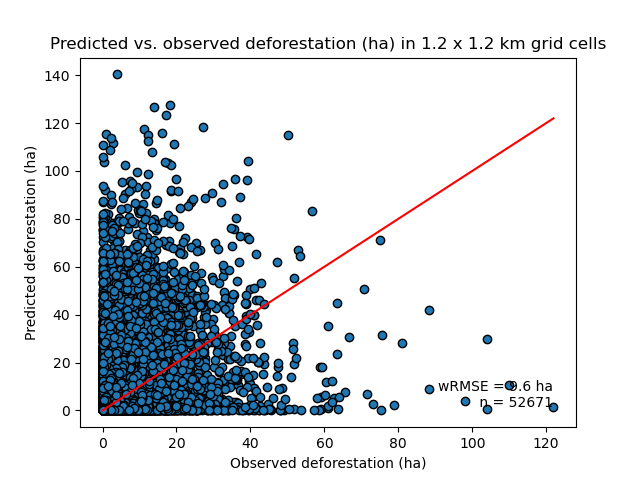

In [21]:
ofile = os.path.join(out_dir, "pred_obs.png")
rmj.validation(
    fcc_file=fcc_directory.name,
    time_interval=5,
    riskmap_file=os.path.join(out_dir, "riskmap.tif"),
    tab_file_defrate=os.path.join(out_dir, "defrate_per_cat.csv"),
    csize=40,
    tab_file_pred=os.path.join(out_dir, "pred_obs.csv"),
    fig_file_pred=ofile,
    figsize=(6.4, 4.8),
    dpi=100, verbose=False)
Image(filename = os.path.join(out_dir,'pred_obs.png') )

## Multiprocessing of deforestation risk mapping

In [5]:
ncpu = mp.cpu_count()
print(f"Number of CPUs: {ncpu}.")

Number of CPUs: 8.


In [ ]:
start_time = time.time()
results_makemap = rmj.makemap(
    fcc_file=fcc_directory.name,
    time_interval=[5, 5],
    output_dir=out_dir,
    clean=False,
    dist_bins=np.arange(0, 1080, step=30),
    win_sizes=np.arange(5, 120, 16),
    ncat=30,
    #parallel=False,
    #ncpu=ncpu,
    methods=["Equal Interval", "Equal Area"],
    csize=40,  # 12 km
    figsize=(6.4, 4.8),
    dpi=100,
    blk_rows=128,
    verbose=True)
sec_seq = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(sec_seq)))

Model calibration and validation
.. Model 0: window size = 5, slicing method = ei.
.. Model 1: window size = 5, slicing method = ea.
.. Model 2: window size = 21, slicing method = ei.
.. Model 3: window size = 21, slicing method = ea.
.. Model 4: window size = 37, slicing method = ei.
.. Model 5: window size = 37, slicing method = ea.
.. Model 6: window size = 53, slicing method = ei.
.. Model 7: window size = 53, slicing method = ea.
.. Model 8: window size = 69, slicing method = ei.
.. Model 9: window size = 69, slicing method = ea.
.. Model 10: window size = 85, slicing method = ei.
.. Model 11: window size = 85, slicing method = ea.
.. Model 12: window size = 101, slicing method = ei.
.. Model 13: window size = 101, slicing method = ea.


In [ ]:
# Results

In [ ]:
# Deforestation Risk and Distance to forest edge

In [ ]:
dist_thresh = results_makemap["dist_thresh"]
print(f"The distance theshold is {dist_thresh} m.")

In [ ]:
ofile = os.path.join(out_dir, "perc_dist.png")
ofile

In [ ]:
# Best model

In [ ]:
ws_hat = results_makemap["ws_hat"]
m_hat = results_makemap["m_hat"]
print(f"The best moving window size is {ws_hat} pixels.")
print(f"The best slicing algorithm is '{m_hat}'.")

In [ ]:
ofile = os.path.join(out_dir, f"pred_obs_ws{ws_hat}_{m_hat}.png")
ofile

In [ ]:
# Risk Map

In [ ]:
ifile = os.path.join(out_dir, f"riskmap_ws{ws_hat}_{m_hat}.tif")
ofile = os.path.join(out_dir, f"riskmap_ws{ws_hat}_{m_hat}.png")
riskmap_fig = rmj.plot.riskmap(
    input_risk_map=ifile,
    maxpixels=1e8,
    output_file=ofile,
    borders=border_file,
    legend=True,
    figsize=(5, 4), dpi=800, linewidth=0.2,)
ofile